In [1]:
import datetime
import pathlib

from parcels import FieldSet, ParticleSet, JITParticle, AdvectionRK4_3D
import parcels
import xarray

from parcels import logger, XarrayDecodedFilter
logger.addFilter(XarrayDecodedFilter())  # Add a filter for the xarray decoding warning

# Subset, lower left corner of my grid
enatl_data_path = pathlib.Path('day_1_5')

In [2]:
import itertools
import xorca.lib
mesh_mask_files = list(itertools.chain(enatl_data_path.glob('coord*.nc'), enatl_data_path.glob('m*.nc')))
datafiles = sorted(enatl_data_path.glob('eNATL60*.nc'))

dataset = xorca.lib.load_xorca_dataset(data_files=datafiles, aux_files=mesh_mask_files)

In [3]:
dataset

<xarray.Dataset>
Dimensions:   (z_c: 237, z_l: 237, y_c: 36, y_r: 36, x_c: 43, x_r: 43, t: 5)
Coordinates: (12/33)
  * z_c       (z_c) int64 1 2 3 4 5 6 7 8 9 ... 230 231 232 233 234 235 236 237
  * z_l       (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 233.5 234.5 235.5 236.5
  * y_c       (y_c) int64 1 2 3 4 5 6 7 8 9 10 ... 27 28 29 30 31 32 33 34 35 36
  * y_r       (y_r) float64 1.5 2.5 3.5 4.5 5.5 6.5 ... 32.5 33.5 34.5 35.5 36.5
  * x_c       (x_c) int64 1 2 3 4 5 6 7 8 9 10 ... 34 35 36 37 38 39 40 41 42 43
  * x_r       (x_r) float64 1.5 2.5 3.5 4.5 5.5 6.5 ... 39.5 40.5 41.5 42.5 43.5
    ...        ...
    e2f       (y_r, x_r) float64 dask.array<chunksize=(36, 43), meta=np.ndarray>
    e3w       (z_l, y_c, x_c) float64 dask.array<chunksize=(2, 36, 43), meta=np.ndarray>
    tmask     (z_c, y_c, x_c) int8 dask.array<chunksize=(2, 36, 43), meta=np.ndarray>
    umask     (z_c, y_c, x_r) int8 dask.array<chunksize=(2, 36, 43), meta=np.ndarray>
    vmask     (z_c, y_r, x_c) int8 dask.array<chunksize=(2, 36, 43), meta=np.ndarray>
    fmask     (z_c, y_r, x_r) int8 dask.array<chunksize=(2, 36, 43), meta=np.ndarray>
Data variables:
    sometauy  (t, y_r, x_c) float32 dask.array<chunksize=(1, 36, 43), meta=np.ndarray>
    somxl010  (t, y_c, x_c) float32 dask.array<chunksize=(1, 36, 43), meta=np.ndarray>
    sosaline  (t, y_c, x_c) float32 dask.array<chunksize=(1, 36, 43), meta=np.ndarray>
    sossheig  (t, y_c, x_c) float32 dask.array<chunksize=(1, 36, 43), meta=np.ndarray>
    sosstsst  (t, y_c, x_c) float32 dask.array<chunksize=(1, 36, 43), meta=np.ndarray>
    sowaflup  (t, y_c, x_c) float32 dask.array<chunksize=(1, 36, 43), meta=np.ndarray>
    sozotaux  (t, y_c, x_r) float32 dask.array<chunksize=(1, 36, 43), meta=np.ndarray>
    vomecrty  (t, z_c, y_r, x_c) float32 dask.array<chunksize=(1, 2, 36, 43), meta=np.ndarray>
    vosaline  (t, z_c, y_c, x_c) float32 dask.array<chunksize=(1, 2, 36, 43), meta=np.ndarray>
    votemper  (t, z_c, y_c, x_c) float32 dask.array<chunksize=(1, 2, 36, 43), meta=np.ndarray>
    vovecrtz  (t, z_l, y_c, x_c) float32 dask.array<chunksize=(1, 2, 36, 43), meta=np.ndarray>
    vozocrtx  (t, z_c, y_c, x_r) float32 dask.array<chunksize=(1, 2, 36, 43), meta=np.ndarray>

Given a dataset, with c-grid already arranged, is this correct? Or should I set the f-points here as in [[NEMO 3D tutorial|https://nbviewer.jupyter.org/github/OceanParcels/parcels/blob/master/parcels/examples/tutorial_nemo_3D.ipynb]]?

In [4]:
variables_from_dataset = {
    'U': 'vozocrtx',
    'V': 'vomecrty',
    'W': 'vovecrtz',
    'T': 'votemper',
    'S': 'vosaline',
}

dimensions_assuming_c_grid = {
    'U': {'lon': 'llon_cr', 'lat': 'llat_cr', 'depth': 'depth_c', 'time': 't'},
    'V': {'lon': 'llon_rc', 'lat': 'llat_rc', 'depth': 'depth_c', 'time': 't'},
    'W': {'lon': 'llon_cc', 'lat': 'llat_cc', 'depth': 'depth_l', 'time': 't'},
    'T': {'lon': 'llon_cc', 'lat': 'llat_cc', 'depth': 'depth_c', 'time': 't'},
    'S': {'lon': 'llon_cc', 'lat': 'llat_cc', 'depth': 'depth_c', 'time': 't'},
}


In [5]:
fieldset_from_dataset = FieldSet.from_xarray_dataset(dataset, variables_from_dataset, dimensions_assuming_c_grid, mesh='spherical')

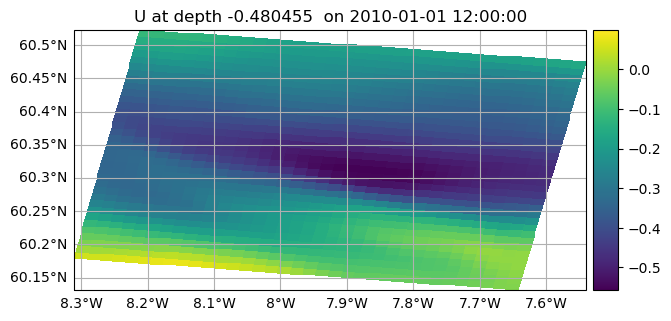

In [6]:
fieldset_from_dataset.U.show()

In [7]:
ds = dataset.isel(dict(y_c=[9, 18], x_r=21, x_c=[], y_r=[]))[['llon_cr', 'llat_cr', 'depth_c']]
ds

<xarray.Dataset>
Dimensions:  (y_c: 2, z_c: 237)
Coordinates:
    llon_cr  (y_c) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    llat_cr  (y_c) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    depth_c  (z_c) float64 dask.array<chunksize=(2,), meta=np.ndarray>
  * z_c      (z_c) int64 1 2 3 4 5 6 7 8 9 ... 230 231 232 233 234 235 236 237
  * y_c      (y_c) int64 10 19
    x_r      float64 22.5
    e1u      (y_c) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    e2u      (y_c) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    e3u      (z_c, y_c) float64 dask.array<chunksize=(2, 2), meta=np.ndarray>
    umask    (z_c, y_c) int8 dask.array<chunksize=(2, 2), meta=np.ndarray>
Data variables:
    *empty*

In [8]:
ds.llon_cr.values

array([-7.883789, -7.857898], dtype=float32)

In [9]:
ds.llat_cr.values

array([60.23912, 60.32742], dtype=float32)

In [10]:
ds.depth_c.isel(dict(z_c=20)).values

array(-52.48403405)

In [11]:
dataset_vw_zero = dataset.copy(deep=True)
vomecrty = 0 * dataset_vw_zero['vomecrty']
vovecrtz = 0 * dataset_vw_zero['vovecrtz']

dataset_vw_zero['vomecrty'] = vomecrty
dataset_vw_zero['vovecrtz'] = vovecrtz

fieldset_vw_zero = FieldSet.from_xarray_dataset(dataset_vw_zero, variables_from_dataset, dimensions_assuming_c_grid, mesh='spherical')

In [12]:
dataset_vw_zero

<xarray.Dataset>
Dimensions:   (z_c: 237, z_l: 237, y_c: 36, y_r: 36, x_c: 43, x_r: 43, t: 5)
Coordinates: (12/33)
  * z_c       (z_c) int64 1 2 3 4 5 6 7 8 9 ... 230 231 232 233 234 235 236 237
  * z_l       (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 233.5 234.5 235.5 236.5
  * y_c       (y_c) int64 1 2 3 4 5 6 7 8 9 10 ... 27 28 29 30 31 32 33 34 35 36
  * y_r       (y_r) float64 1.5 2.5 3.5 4.5 5.5 6.5 ... 32.5 33.5 34.5 35.5 36.5
  * x_c       (x_c) int64 1 2 3 4 5 6 7 8 9 10 ... 34 35 36 37 38 39 40 41 42 43
  * x_r       (x_r) float64 1.5 2.5 3.5 4.5 5.5 6.5 ... 39.5 40.5 41.5 42.5 43.5
    ...        ...
    e2f       (y_r, x_r) float64 dask.array<chunksize=(36, 43), meta=np.ndarray>
    e3w       (z_l, y_c, x_c) float64 dask.array<chunksize=(2, 36, 43), meta=np.ndarray>
    tmask     (z_c, y_c, x_c) int8 dask.array<chunksize=(2, 36, 43), meta=np.ndarray>
    umask     (z_c, y_c, x_r) int8 dask.array<chunksize=(2, 36, 43), meta=np.ndarray>
    vmask     (z_c, y_r, x_c) int8 dask.array<chunksize=(2, 36, 43), meta=np.ndarray>
    fmask     (z_c, y_r, x_r) int8 dask.array<chunksize=(2, 36, 43), meta=np.ndarray>
Data variables:
    sometauy  (t, y_r, x_c) float32 dask.array<chunksize=(1, 36, 43), meta=np.ndarray>
    somxl010  (t, y_c, x_c) float32 dask.array<chunksize=(1, 36, 43), meta=np.ndarray>
    sosaline  (t, y_c, x_c) float32 dask.array<chunksize=(1, 36, 43), meta=np.ndarray>
    sossheig  (t, y_c, x_c) float32 dask.array<chunksize=(1, 36, 43), meta=np.ndarray>
    sosstsst  (t, y_c, x_c) float32 dask.array<chunksize=(1, 36, 43), meta=np.ndarray>
    sowaflup  (t, y_c, x_c) float32 dask.array<chunksize=(1, 36, 43), meta=np.ndarray>
    sozotaux  (t, y_c, x_r) float32 dask.array<chunksize=(1, 36, 43), meta=np.ndarray>
    vomecrty  (t, z_c, y_r, x_c) float32 dask.array<chunksize=(1, 2, 36, 43), meta=np.ndarray>
    vosaline  (t, z_c, y_c, x_c) float32 dask.array<chunksize=(1, 2, 36, 43), meta=np.ndarray>
    votemper  (t, z_c, y_c, x_c) float32 dask.array<chunksize=(1, 2, 36, 43), meta=np.ndarray>
    vovecrtz  (t, z_l, y_c, x_c) float32 dask.array<chunksize=(1, 2, 36, 43), meta=np.ndarray>
    vozocrtx  (t, z_c, y_c, x_r) float32 dask.array<chunksize=(1, 2, 36, 43), meta=np.ndarray>

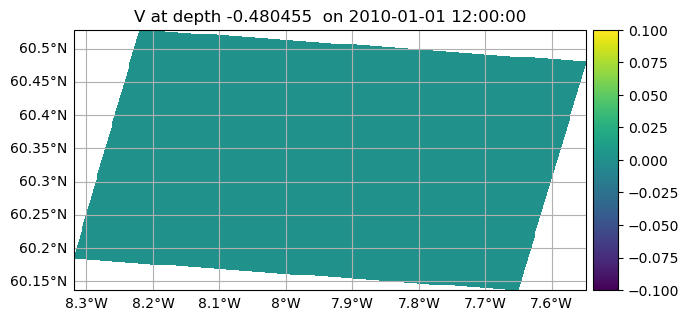

In [13]:
fieldset_vw_zero.V.show()

In [14]:
start_point = (-7.883789, 60.239120)  # y_c = 9, x_r = 21
stop_point = (-7.857898, 60.327419)  # y_c = 18, x_r = 21
depth = 52.48403405  # z_c = 20

pset = ParticleSet.from_line(
    fieldset=fieldset_vw_zero,
    pclass=JITParticle,
    size=10,
    start=start_point,
    finish=stop_point,
    depth=depth,
)
kernels = pset.Kernel(AdvectionRK4_3D)

def DeleteParticle(particle, fieldset, time):
    particle.delete()

output_file = pset.ParticleFile(name='output_dataset_vw_zero.zarr', outputdt=datetime.timedelta(hours=6))
starttime = datetime.datetime(2010, 1, 1, 12)
endtime = starttime + datetime.timedelta(days=4)
runtime = endtime - starttime

In [15]:
pset.execute(kernels, runtime=runtime, dt=datetime.timedelta(hours=6), output_file=output_file, recovery={parcels.ErrorCode.ErrorOutOfBounds: DeleteParticle})

INFO: Compiled ArrayJITParticleAdvectionRK4_3D ==> /var/folders/kk/m6gqzmx50nxfthwxklx9dr640000gp/T/parcels-502/lib1718aa4f4088db8f8ca285da3c904b99_0.so


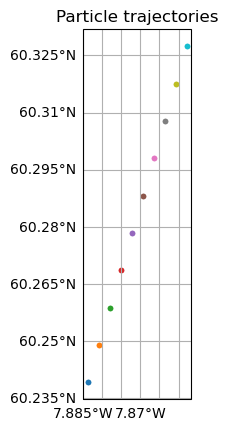

<module 'matplotlib.pyplot' from '/Users/niten/.local/anaconda/envs/opt-m1-lagrangian/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [16]:
parcels.plotTrajectoriesFile('output_dataset_vw_zero.zarr')